In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from random import sample
numofDrug = 708
numofProtein = 1512
featureFusion = list()
positiveFeature = list()
negativeFeature = list()
featureLable = list()

In [2]:
#def featureFusion(featureFile1,featureFile2,interactionFile):
feature1 = np.loadtxt("DrugFeature.txt")
feature1Norm = preprocessing.normalize(feature1,axis = 0)
feature2 = np.loadtxt("ProteinFeature.txt")
feature2Norm = preprocessing.normalize(feature2,axis = 0)
np.savetxt("drugFeatureNorm.txt",feature1Norm)
np.savetxt("proteinFeatureNorm.txt",feature2Norm)
interaction = np.loadtxt("mat_drug_protein.txt")
np.shape(interaction)  
for i in range(numofDrug):
    for j in range(numofProtein):
        if interaction[i][j]==1:
            positiveFeature.append(np.concatenate((feature1Norm[i],feature2Norm[j]),axis = None))
        else:
            negativeFeature.append(np.concatenate((feature1Norm[i],feature2Norm[j]),axis = None))
#         featureFusion.append(np.concatenate((feature1Norm[i],feature2Norm[j]),axis = None))
#         featureLable.append(interaction[i][j])
len(positiveFeature)

1923

In [1]:
# np.savetxt("featureFusion.txt",featureFusion)
# np.savetxt("featureLable.txt",featureLable)
#np.savetxt("positiveFeature.txt",positiveFeature)
#np.savetxt("negativeFeature.txt",negativeFeature)

In [3]:
negativeSamples = sample(negativeFeature,2*len(positiveFeature))
inputData = list()
inputData = np.concatenate((positiveFeature,negativeSamples))
inputLable = np.repeat(np.array([1,0]),[len(positiveFeature),len(negativeSamples)],axis = 0)
len(inputLable)

5769

SVM: 10 fold cross validation

In [22]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
X_train,X_test,y_train,y_test = train_test_split(inputData,inputLable,test_size = 0.1, random_state = 0)
modelSVM = svm.SVC(kernel = "linear",C=1,probability=True).fit(X_train,y_train)
y_predict = modelSVM.predict_proba(X_test)
# fpr,tpr,thresholds
#modelSVM.score(X_test,y_test)

array([[0.90092165, 0.09907835],
       [0.167039  , 0.832961  ],
       [0.78658255, 0.21341745],
       ...,
       [0.04918386, 0.95081614],
       [0.35909781, 0.64090219],
       [0.3195594 , 0.6804406 ]])

In [26]:
fpr,tpr,thresholds= roc_curve(y_test,y_predict[:,1]) #for positive
roc_auc = auc(fpr,tpr)
roc_auc

0.872829998941463

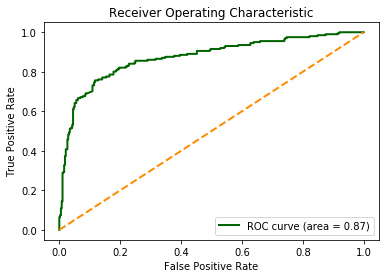

In [29]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr,tpr,color = "darkgreen",lw = lw, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1],color = 'darkorange',lw = lw, linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc = "lower right")
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score 
scoresSVM = cross_val_score(modelSVM,inputData,inputLable,cv=10)
scoresSVM

array([0.82179931, 0.80622837, 0.80622837, 0.79202773, 0.80069324,
       0.79202773, 0.77083333, 0.80902778, 0.84375   , 0.82986111])

In [11]:
print("Accuracy:%0.2f(+/- %0.2f)" % (scoresSVM.mean(),scoresSVM.std()*2))

Accuracy:0.81(+/- 0.04)


KNN: 10 fold cross validation

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
scoresKNN = cross_val_score(knn, inputData, inputLable, cv=10, scoring='accuracy')

In [5]:
scoresKNN

array([0.55882353, 0.62456747, 0.59342561, 0.58405546, 0.60485269,
       0.55459272, 0.59027778, 0.578125  , 0.60243056, 0.59375   ])

In [16]:
print("Accuracy:%0.2f(+/- %0.2f)" % (scoresKNN.mean(),scoresKNN.std()*2))

Accuracy:0.58(+/- 0.02)


gcForest 

In [ ]:
import argparse
import numpy as np
import sys
from keras.datasets import mnist
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
sys.path.insert(0, "lib")

from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", dest="model", type=str, default=None, help="gcfoest Net Model File")
    args = parser.parse_args()
    return args

def get_toy_config():
    config = {}
    ca_config = {}
    ca_config["random_state"] = 0
    ca_config["max_layers"] = 100
    ca_config["early_stopping_rounds"] = 3
    ca_config["n_classes"] = 2
    ca_config["estimators"] = []
    ca_config["estimators"].append(
            {"n_folds": 5, "type": "XGBClassifier", "n_estimators": 10, "max_depth": 5,
             "objective": "multi:softprob", "silent": True, "nthread": -1, "learning_rate": 0.1} )
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "n_estimators": 10, "max_depth": None, "n_jobs": -1})
    ca_config["estimators"].append({"n_folds": 5, "type": "ExtraTreesClassifier", "n_estimators": 10, "max_depth": None, "n_jobs": -1})
    ca_config["estimators"].append({"n_folds": 5, "type": "LogisticRegression"})
    config["cascade"] = ca_config
    return config

if __name__ == "__main__":
    args = parse_args()
    if args.model is None:
        config = get_toy_config()
    else:
        config = load_json(args.model)

    gc = GCForest(config)
    # If the model you use cost too much memory for you.
    # You can use these methods to force gcforest not keeping model in memory
    # gc.set_keep_model_in_mem(False), default is TRUE.

    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # X_train, y_train = X_train[:2000], y_train[:2000]
    X_train = X_train[:, np.newaxis, :, :]
    X_test = X_test[:, np.newaxis, :, :]


    X_train_enc = gc.fit_transform(X_train, y_train)
    # X_enc is the concatenated predict_proba result of each estimators of the last layer of the GCForest model
    # X_enc.shape =
    #   (n_datas, n_estimators * n_classes): If cascade is provided
    #   (n_datas, n_estimators * n_classes, dimX, dimY): If only finegrained part is provided
    # You can also pass X_test, y_test to fit_transform method, then the accracy on test data will be logged when training.
    # X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)
    # WARNING: if you set gc.set_keep_model_in_mem(True), you would have to use
    # gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test) to evaluate your model.
    
    y_pred = gc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy of GcForest = {:.2f} %".format(acc * 100))

    # You can try passing X_enc to another classfier on top of gcForest.e.g. xgboost/RF.
    X_test_enc = gc.transform(X_test)
    X_train_enc = X_train_enc.reshape((X_train_enc.shape[0], -1))
    X_test_enc = X_test_enc.reshape((X_test_enc.shape[0], -1))
    X_train_origin = X_train.reshape((X_train.shape[0], -1))
    X_test_origin = X_test.reshape((X_test.shape[0], -1))
    X_train_enc = np.hstack((X_train_origin, X_train_enc))
    X_test_enc = np.hstack((X_test_origin, X_test_enc))
    print("X_train_enc.shape={}, X_test_enc.shape={}".format(X_train_enc.shape, X_test_enc.shape))
    clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1)
    clf.fit(X_train_enc, y_train)
    y_pred = clf.predict(X_test_enc)
    acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy of Other classifier using gcforest's X_encode = {:.2f} %".format(acc * 100))

    # dump
    with open("test.pkl", "wb") as f:
        pickle.dump(gc, f, pickle.HIGHEST_PROTOCOL)
    # load
    with open("test.pkl", "rb") as f:
        gc = pickle.load(f)
    y_pred = gc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy of GcForest (save and load) = {:.2f} %".format(acc * 100))

In [15]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
X = inputData
y = inputLable
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,random_state=random_state)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


NameError: name 'random_state' is not defined